## The DeepONet method for Parametric PDEs
- Implementation is also available in Kaggle notebook:  [https://www.kaggle.com/code/yhzang32/deeponet4darcyflow](https://www.kaggle.com/code/yhzang32/deeponet4darcyflow)
- Datasets in the lesson are available through: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

### (1) Generating training data 
The Darcy's equation:
\begin{equation}
\begin{split}
-\nabla\cdot(a\nabla u) &= f \\
u &= 0
\end{split}
\end{equation}
The goal of the parametric PDE problem is to learn a mapping from the PDE coefficient $a$ to the solution $u$, i.e.,:
$$
\mathcal{G}: a(x)\in\mathcal{A}\rightarrow u(x)\in\mathcal{U}
$$

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
The shape of a_train: torch.Size([1000, 841])
The shape of u_train: torch.Size([1000, 841])
The shape of x_train: torch.Size([841, 2])


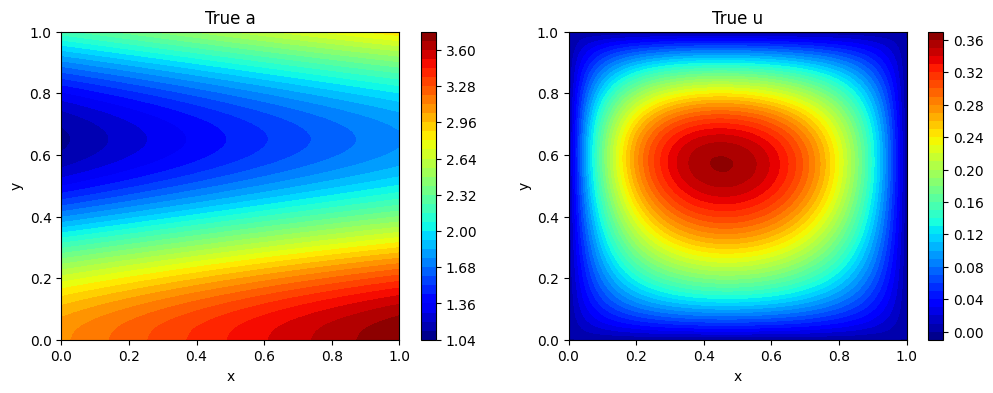

In [1]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
device = 'cpu'
dtype = torch.float32
######################################
# Load training data
######################################
data_train = h5py.File('data_train.mat', 'r')
print(data_train.keys()) 
#
def get_data(data, ndata=1000):
    # The labeled training data (a,u)
    a = np.array(data["coeff"][...,:ndata]).T
    u = np.array(data["sol"][:,:ndata]).T
    # The coordinates
    x1, x2 = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np.vstack([x1.ravel(), x2.ravel()]).T
    gridx = mesh.reshape(-1, 2)
    #
    a = torch.tensor(a, dtype=dtype).reshape(ndata, -1)
    u = torch.tensor(u, dtype=dtype).reshape(ndata, -1)
    x = torch.tensor(gridx, dtype=dtype)
    return a, u, x, gridx
a_train, u_train, x_train, gridx = get_data(data_train)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of x_train:', x_train.shape)

####### Visualize the training data 
a_show, u_show = a_train[0], u_train[0]
#
mesh = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
x_plot, y_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(a_show), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True a')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_show), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True u')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()

### (2) The DeepONet architecture 

In [2]:
import torch.nn as nn
#
class DeepONet(nn.Module):
    
    def __init__(self, layers_trunk, layers_branch, branch_type=None):
        super(DeepONet, self).__init__()
        # The trunk network
        self.activation_trunk = nn.ReLU()
        self.trunk_net(layers_trunk)
        
        # The branch network
        self.activation_branch = nn.ReLU()
        if branch_type=='cnn':
            self.branch_net_cnn(layers_branch)
        else:
            self.branch_net_mlp(layers_branch)
            
        # The bias term
        self.bias = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype))

    def branch_net_mlp(self, layers_branch):
        '''The branch network (MLP network)'''
        # Network Sequential
        net = []
        hidden_in = layers_branch[0]
        for hidden in layers_branch[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in = hidden
        self.branch = nn.Sequential(*net)

    def branch_net_cnn(self, layers_barnch):
        '''The branch network (CNN network)'''
        # Network Sequential
        net = []
        hidden_in = layers_barnch[0]
        for hidden in layers_barnch[1:]:
            net.append(nn.Conv2d(hidden_in, hidden, kernel_size=(5,5), 
                                 stride=2, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in =  hidden 
        self.branch = nn.Sequential(*net)
        
    def trunk_net(self, layers_trunk):
        '''The trunk network'''
        # Network Sequential
        net = []
        hidden_in = layers_trunk[0]
        for hidden in layers_trunk[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_trunk)
            hidden_in = hidden
        self.trunk = nn.Sequential(*net)
        
    def forward(self, x, a):
        ''' 
        Input:
            x: size(mesh_size, x_size)
            a: size(batch_size, a_size)
        '''
        # size(mesh_size, x_size) -> size(mesh_size, p)
        t = self.trunk(x)
        # size(batch_size, a_size) -> size(batch_size, p)
        b = self.branch(a)
        #
        output = torch.einsum("bp,mp->bm", b, t) + self.bias
        return output
#
layers_trunk = [x_train.shape[-1], 128, 128, 128, 128]
layers_branch = [a_train.shape[-1], 128, 128, 128, 128]
#
model_u = DeepONet(layers_trunk, layers_branch).to(device)
#
from torchsummary import summary
summary(model_u, [(2,), (841,)], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
              ReLU-2                  [-1, 128]               0
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
              ReLU-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
              ReLU-8                  [-1, 128]               0
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
             ReLU-11                  [-1, 128]               0
             ReLU-12                  [-1, 128]               0
           Linear-13                  [-1, 128]         107,776
             ReLU-14                  [

### (3) The loss function
$$
L(\theta) = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} \sqrt{\sum_{j=1}^{N_p} \left| \mathcal{G}_\theta(a^{(i)}(\Xi))(x_j) - u^{(i)}(x_j) \right|^2}
$$

In [3]:
class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
    
    def loss_data(self, a_batch, u_batch):
        '''loss term'''
        x, a, u = x_train.to(self.device), a_batch.to(self.device), u_batch.to(self.device)
        #
        u_pred = self.u_model(x, a)
        loss = torch.norm(u-u_pred, 2, 1)
        loss = torch.mean(loss)
        
        return loss 

### (4) Training the model

#### (4.1) Defining the dataloader function

In [4]:
from torch.utils.data import Dataset, DataLoader
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, a:torch.tensor, u:torch.tensor):
        '''
        Input:
            a: size(batch_size, a_size)
            u: size(batch_size, u_size)
        '''
        self.a = a 
        self.u = u
    
    def __getitem__(self, index):
        return self.a[index], self.u[index]

    def __len__(self):
        return self.a.shape[0]
        
##############
train_loader = DataLoader(MyDataset(a_train, u_train), batch_size=50, shuffle=True)
for a_batch, u_batch in train_loader:
    print('a_batch shape:', a_batch.shape, 'u_batch shape:', u_batch.shape)

a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u_batch shape: torch.Size([50, 841])
a_batch shape: torch.Size([50, 841]) u

#### (4.2) The training of the model

In [5]:
from tqdm import trange
import time
############ Training setups
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_list = []
############ The training process
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for a_batch, u_batch in train_loader:
        lossClass = LossClass(model_u)
        loss_train = lossClass.loss_data(a_batch, u_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    scheduler.step()  # Adjust learning rate
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
print('The consuming time is:', time.time()-t0)

  5%|██                                      | 101/2000 [00:07<02:12, 14.38it/s]

Epoch:99, The loss is:0.19203028082847595


 10%|████                                    | 203/2000 [00:14<01:57, 15.32it/s]

Epoch:199, The loss is:0.1477503478527069


 15%|██████                                  | 301/2000 [00:21<02:09, 13.17it/s]

Epoch:299, The loss is:0.11085285246372223


 20%|████████                                | 401/2000 [00:28<01:58, 13.48it/s]

Epoch:399, The loss is:0.2023458480834961


 25%|██████████                              | 501/2000 [00:35<01:48, 13.86it/s]

Epoch:499, The loss is:0.14876048266887665


 30%|████████████                            | 601/2000 [00:42<01:32, 15.06it/s]

Epoch:599, The loss is:0.09639846533536911


 35%|██████████████                          | 701/2000 [00:49<01:35, 13.57it/s]

Epoch:699, The loss is:0.06649374961853027


 40%|████████████████                        | 803/2000 [00:57<01:15, 15.76it/s]

Epoch:799, The loss is:0.06340424716472626


 45%|██████████████████                      | 903/2000 [01:04<01:11, 15.44it/s]

Epoch:899, The loss is:0.06413769721984863


 50%|███████████████████▌                   | 1003/2000 [01:11<01:00, 16.58it/s]

Epoch:999, The loss is:0.058721862733364105


 55%|█████████████████████▌                 | 1103/2000 [01:18<01:00, 14.83it/s]

Epoch:1099, The loss is:0.050977349281311035


 60%|███████████████████████▍               | 1201/2000 [01:25<00:56, 14.03it/s]

Epoch:1199, The loss is:0.04697755351662636


 65%|█████████████████████████▎             | 1301/2000 [01:32<00:51, 13.58it/s]

Epoch:1299, The loss is:0.04547009617090225


 70%|███████████████████████████▎           | 1401/2000 [01:39<00:53, 11.21it/s]

Epoch:1399, The loss is:0.05080650374293327


 75%|█████████████████████████████▎         | 1501/2000 [01:47<00:33, 14.93it/s]

Epoch:1499, The loss is:0.0435388945043087


 80%|███████████████████████████████▎       | 1603/2000 [01:54<00:25, 15.73it/s]

Epoch:1599, The loss is:0.03858102113008499


 85%|█████████████████████████████████▏     | 1701/2000 [02:01<00:20, 14.75it/s]

Epoch:1699, The loss is:0.03846754506230354


 90%|███████████████████████████████████    | 1801/2000 [02:08<00:14, 13.41it/s]

Epoch:1799, The loss is:0.038328684866428375


 95%|█████████████████████████████████████  | 1903/2000 [02:14<00:05, 16.42it/s]

Epoch:1899, The loss is:0.0386342816054821


100%|███████████████████████████████████████| 2000/2000 [02:22<00:00, 14.08it/s]

Epoch:1999, The loss is:0.03761529177427292
The consuming time is: 142.04552388191223


### (5) Performance on testing dataset
The relative error:
$$
L^2 = \sqrt{\sum_i\frac{\|u(x_i)-u_{nn}(x_i)\|^2}{\|u(x_i)\|^2}}
$$
where $u$ represents the true solution and $u_{nn}$ is the network approximation.

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
The shape of a_test: torch.Size([200, 841])
The shape of u_test: torch.Size([200, 841])
The shape of x_test: torch.Size([841, 2])
The shape of u_pred: torch.Size([200, 841])
The l2 error: tensor([0.0162, 0.0155, 0.0057, 0.0146, 0.0031, 0.0041, 0.0037, 0.0028, 0.0037,
        0.0027, 0.0037, 0.0032, 0.0233, 0.0042, 0.0033, 0.0188, 0.0029, 0.0228,
        0.0030, 0.0031, 0.0034, 0.0036, 0.0026, 0.0038, 0.0044, 0.0132, 0.0036,
        0.0054, 0.0030, 0.0126, 0.0034, 0.0035, 0.0044, 0.0040, 0.0026, 0.0028,
        0.0058, 0.0027, 0.0040, 0.0179, 0.0027, 0.0242, 0.0039, 0.0276, 0.0036,
        0.0169, 0.0028, 0.0031, 0.0029, 0.0184, 0.0033, 0.0162, 0.0023, 0.0034,
        0.0157, 0.0037, 0.0039, 0.0093, 0.0038, 0.0029, 0.0032, 0.0029, 0.0207,
        0.0119, 0.0051, 0.0087, 0.0055, 0.0025, 0.0030, 0.0160, 0.0031, 0.0214,
        0.0028, 0.0149, 0.0026, 0.0036, 0.0189, 0.0107, 0.0031, 0.0037, 0.0033,
        0.0058

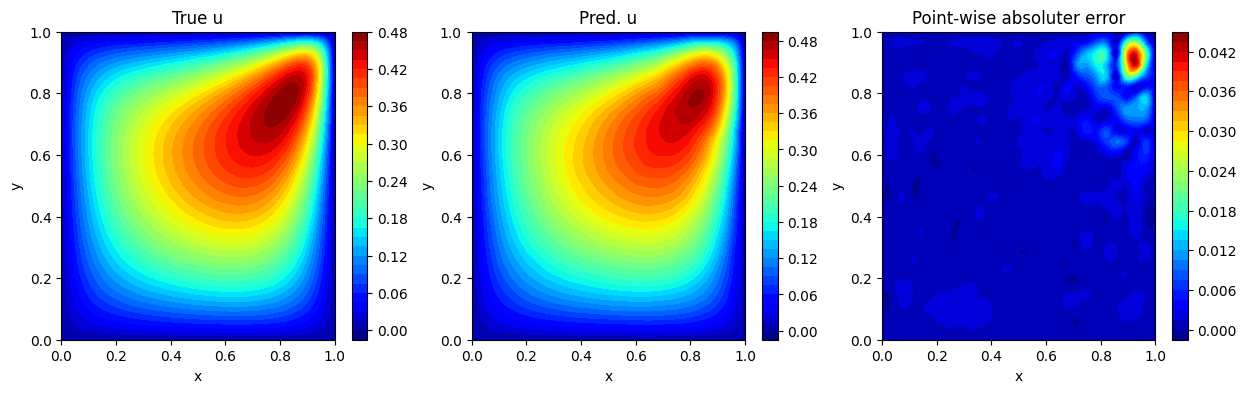

In [6]:
######################################
# Load testing data
######################################
data_test = h5py.File('data_test.mat', 'r')
print(data_test.keys()) 
#
a_test, u_test, x_test, gridx_test = get_data(data_test, ndata=200)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of x_test:', x_test.shape)
#######################################
# The L2 relative error
#######################################
def L2_error(u, u_pred):
    ''' '''
    l2 = torch.norm(u-u_pred, 2, 1) / torch.norm(u, 2, 1)
    return l2
# Make prediction with trained model
u_test_pred = model_u(x_test.to(device), a_test.to(device)).detach().cpu()
print('The shape of u_pred:', u_test_pred.shape)
# compute the L2 relative error
l2_err = L2_error(u_test, u_test_pred)
print('The l2 error:', l2_err)
print('The average l2 error:', torch.mean(l2_err))
#######################################
# Visualize the prediction and truth u
#######################################
u_true, u_pred = u_test[0], u_test_pred[0]
#
mesh = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
x_plot, y_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_true), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True u')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_pred), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('Pred. u')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(np.abs(u_true-u_pred)), (x_plot, y_plot), method='cubic')
cntr2 = axs.flat[:][2].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr2, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absoluter error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')
#
plt.show()

#  Exercise: Burger's Equation

\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (0,1),\ t\in(0,1] 
\end{equation}
We set $\nu=0.1$ and consider the periodic boundary condition here, i.e.:
$$
u(x-\pi, t) = u(x+\pi, t),\quad t\in(0,1]
$$
The initial condition is 
$$u(x,t=0)=a(x).$$

Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

### Training dataset
- **a_train:** 1000 instances of $a(x)$ on $N=128$ points 
- **uT_train:** 1000 instances of $u(t=T, x)$ on $N=128$ points
- **x_train:** $N=128$ points

### Testing dataset
- **a_test:** 200 instances of $a(x)$ on $N=128$ points 
- **uT_test:** 200 instances of $u(t=T, x)$ on $N=128$ points
- **x_test:** $N=128$ points 

The shape of a_train: torch.Size([1000, 128])
The shape of uT_train: torch.Size([1000, 128])
The shape of x_trian: torch.Size([128, 1])


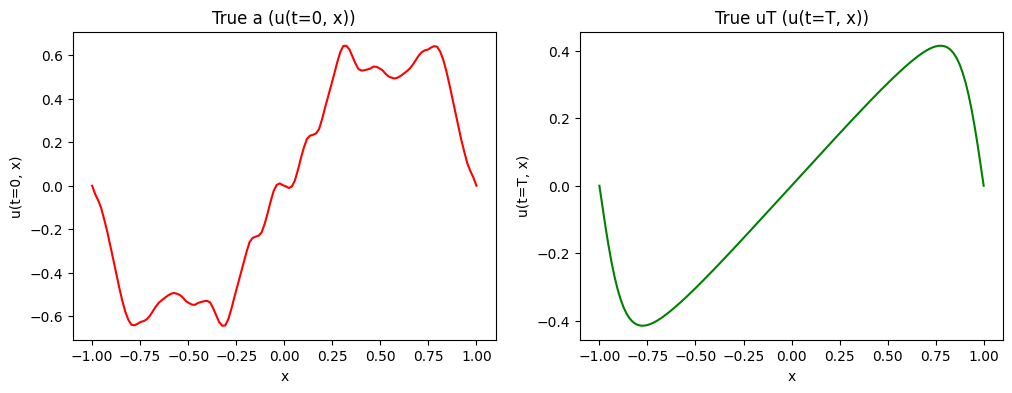

In [1]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(1234)
device = 'cpu'
dtype = torch.float32
######################################
# Load training data
######################################
data_train = h5py.File('Burgers_train.mat', 'r')
#
def get_data(data, dtype):
    a = torch.tensor(np.array(data["u0"]).T, dtype=dtype)
    u = torch.tensor(np.array(data["u_sol"]).T, dtype=dtype)
    uT = u[:,-1,:]
    #
    gridx = torch.tensor(np.array(data['x_mesh']), dtype=dtype)
    #
    a = a.reshape(a.shape[0], -1)
    uT = uT.reshape(a.shape[0], -1)
    
    return a, uT, gridx
#
a_train, uT_train, x_train = get_data(data_train, dtype)
print('The shape of a_train:', a_train.shape)
print('The shape of uT_train:', uT_train.shape)
print('The shape of x_trian:', x_train.shape)

####### Visualize the training data 
a_show, uT_show = a_train[0], uT_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
axs.flat[:][0].plot(x_train.flatten(), a_show.flatten(), color='r')
axs.flat[:][0].set_title('True a (u(t=0, x))')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('u(t=0, x)')
#
axs.flat[:][1].plot(x_train.flatten(), uT_show.flatten(), color='green')
axs.flat[:][1].set_title('True uT (u(t=T, x))')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('u(t=T, x)')
#
plt.show()